In [28]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import mean_squared_error, mean_absolute_error
from pandas_datareader.data import DataReader
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime, timedelta

yf.pdr_override()
import keras

import warnings

warnings.filterwarnings("ignore")


def Dataset(Data, Date):
    # Ensure the 'Date' column is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(Data["Date"]):
        Data["Date"] = pd.to_datetime(Data["Date"])

    # Filter data to create training and testing datasets
    Test_data = Data[Data["Date"] >= Date]
    Test_Data = Data[Data["Date"] >= Date]["Adj Close"].to_numpy()
    Train_Data = Data[Data["Date"] < Date]["Adj Close"].to_numpy()

    # Initialize lists to collect training and test sets
    Data_Train, Data_Test = [], []

    # Populate training data
    for i in range(0, len(Train_Data), 5):
        if i + 5 <= len(
            Train_Data
        ):  # Ensure there's enough data to form a complete sequence
            Data_Train.append(Train_Data[i : i + 5])

    # Convert lists to numpy arrays and reshape
    Data_Train_X = np.array([x[:-1] for x in Data_Train]).reshape(-1, 4, 1)
    Data_Train_Y = np.array([x[-1] for x in Data_Train]).reshape(-1, 1)

    # Populate test data similarly
    for i in range(0, len(Test_Data), 5):
        if i + 5 <= len(
            Test_Data
        ):  # Ensure there's enough data to form a complete sequence
            Data_Test.append(Test_Data[i : i + 5])

    Data_Test_X = np.array([x[:-1] for x in Data_Test]).reshape(-1, 4, 1)
    Data_Test_Y = np.array([x[-1] for x in Data_Test]).reshape(-1, 1)

    return Data_Train_X, Data_Train_Y, Data_Test_X, Data_Test_Y


import pandas as pd
import numpy as np


def walk_forward_validation(model, data, n_splits=5):
    # Convert 'Date' to datetime if it isn't already
    if not pd.api.types.is_datetime64_any_dtype(data["Date"]):
        data["Date"] = pd.to_datetime(data["Date"])

    # Sort data by date to ensure correct chronological splitting
    data.sort_values("Date", inplace=True)

    # Generate split dates for walk-forward validation
    total_days = (data["Date"].iloc[-1] - data["Date"].iloc[0]).days
    split_length = total_days // n_splits
    split_dates = [
        data["Date"].iloc[0] + pd.Timedelta(days=split_length * i)
        for i in range(1, n_splits)
    ]

    history = {"loss": [], "val_loss": [], "rmse": [], "val_rmse": []}

    # Initial train split date is the first date in the dataframe
    train_start_date = data["Date"].iloc[0]

    for split_date in split_dates:
        # Use the Dataset function to split data at the current split date
        X_train, y_train, X_test, y_test = Dataset(data, split_date)

        model.compile(
            optimizer="adam",
            loss="mse",
            metrics=[tf.keras.metrics.RootMeanSquaredError()],
        )
        hist = model.fit(X_train, y_train, epochs=100, validation_data=(X_test, y_test))

        history["loss"].extend(hist.history["loss"])
        history["val_loss"].extend(hist.history["val_loss"])
        history["rmse"].extend(hist.history["root_mean_squared_error"])
        history["val_rmse"].extend(hist.history["val_root_mean_squared_error"])

        predictions = model.predict(X_test)
        print(predictions.shape)
        print(y_test.shape)
        print(X_test.shape)
        rmse = np.sqrt(mean_squared_error(y_test, predictions.reshape(-1, 1)))
        print(f"Validation RMSE for split ending on {split_date}: {rmse}")

    # Add additional visualization or return statements as needed

    # Plot training/validation loss
    plt.figure(figsize=(14, 7))
    plt.subplot(1, 2, 1)
    plt.plot(history["loss"], label="Training Loss")
    plt.plot(history["val_loss"], label="Validation Loss")
    plt.title("Model Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    # Plot RMSE
    plt.subplot(1, 2, 2)
    plt.plot(history["rmse"], label="Training RMSE")
    plt.plot(history["val_rmse"], label="Validation RMSE")
    plt.title("Model RMSE")
    plt.xlabel("Epoch")
    plt.ylabel("RMSE")
    plt.legend()

    plt.show()
    return history  # Example of potential return value


# walk_forward_validation(model, data)
def Model():
    model = tf.keras.models.Sequential(
        [
            tf.keras.layers.LSTM(
                200,
                input_shape=(5, 1),
                activation=tf.nn.leaky_relu,
                return_sequences=True,
            ),
            tf.keras.layers.LSTM(200, activation=tf.nn.leaky_relu),
            tf.keras.layers.Dense(200, activation=tf.nn.leaky_relu),
            tf.keras.layers.Dense(100, activation=tf.nn.leaky_relu),
            tf.keras.layers.Dense(50, activation=tf.nn.leaky_relu),
            tf.keras.layers.Dense(1, activation=tf.nn.leaky_relu),
        ]
    )
    return model




[*********************100%%**********************]  1 of 1 completed

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1100 entries, 0 to 1099
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1100 non-null   datetime64[ns]
 1   Open       1100 non-null   float64       
 2   High       1100 non-null   float64       
 3   Low        1100 non-null   float64       
 4   Close      1100 non-null   float64       
 5   Adj Close  1100 non-null   float64       
 6   Volume     1100 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 60.3 KB
Epoch 1/100


2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 251ms/step - loss: 8263.6533 - root_mean_squared_error: 89.6823 - val_loss: 21352.1504 - val_root_mean_squared_error: 144.4430
Epoch 2/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - loss: 6981.5137 - root_mean_squared_error: 83.5349 - val_loss: 15009.2080 - val_root_mean_squared_error: 121.1401
Epoch 3/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 4810.7793 - root_mean_squared_error: 71.4331 - val_loss: 5105.7944 - val_root_mean_squared_error: 70.7440
Epoch 4/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - loss: 1540.0857 - root_mean_squared_error: 42.1222 - val_loss: 1304.9677 - val_root_mean_squared_error: 35.5934
Epoch 5/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - loss: 494.9532 - root_mean_squared_error: 19.8726 - val_loss: 5340.4048 - val_root_mean_squared_error: 72.1139
Epoch 6/100
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 1114.4453 - root_mean_squared_error: 35.1743 - val_loss: 691.2027 - val_root_mean_squared_error: 25.8543
Epoch 7/100
2/2 ━━━━━━━━━

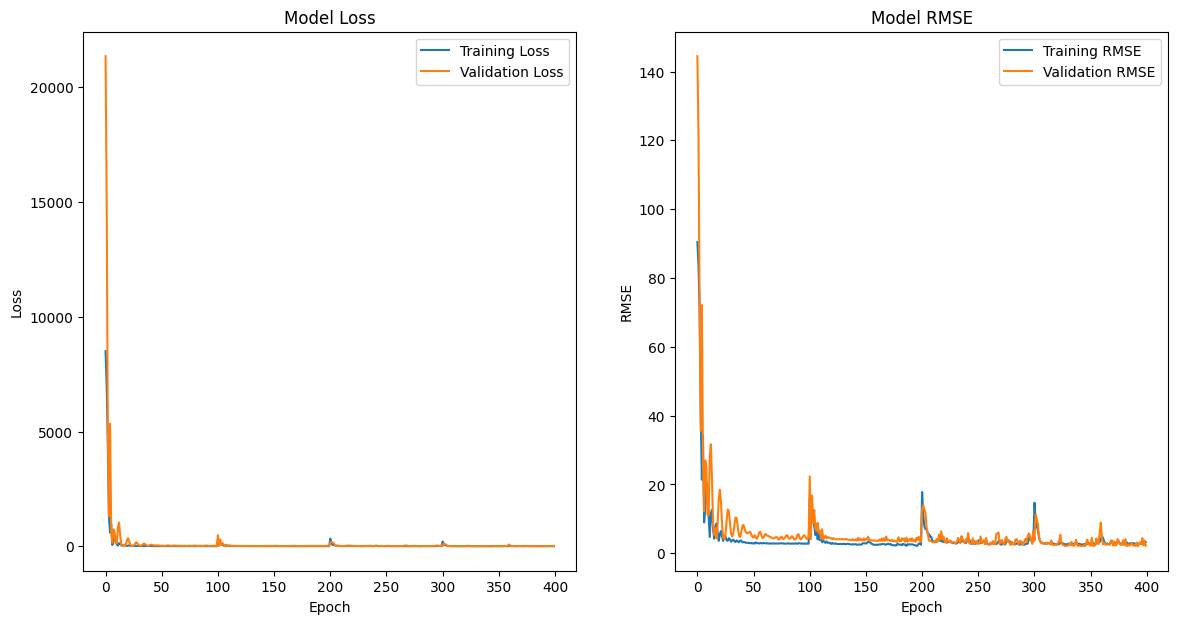

,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-02,74.059998,75.150002,73.797501,75.087502,72.960457,135480400
1,2020-01-03,74.287498,75.144997,74.125000,74.357498,72.251144,146322800
2,2020-01-06,73.447502,74.989998,73.187500,74.949997,72.826851,118387200
3,2020-01-07,74.959999,75.224998,74.370003,74.597504,72.484329,108872000
4,2020-01-08,74.290001,76.110001,74.290001,75.797501,73.650352,132079200


In [29]:
AAPL = pdr.get_data_yahoo("AAPL", start="2020-01-01", end=datetime.now())
AAPL.reset_index(inplace=True)
AAPL.rename(columns={"index": "Date"}, inplace=True)
AAPL["Date"] = pd.to_datetime(AAPL["Date"])
model = Model()
AAPL.info()
AAPL.describe()
AAPL_Model = Model()
AAPL_Model.compile(optimizer=tf.keras.optimizers.Adam(), loss="mse")
walk_forward_validation(AAPL_Model, AAPL)

AAPL.head()

[*********************100%%**********************]  1 of 1 completed

predicted=152.917826, expected=153.785843
predicted=153.775175, expected=150.874664
predicted=151.081753, expected=149.221069
predicted=149.351217, expected=152.963989
predicted=152.711325, expected=155.360245
predicted=155.153375, expected=152.211441
predicted=152.406464, expected=151.241058
predicted=151.342743, expected=148.953735
predicted=149.134390, expected=149.290390
predicted=149.299334, expected=150.270691
predicted=150.203179, expected=148.369522
predicted=148.492495, expected=141.081757
predicted=141.604859, expected=136.843735
predicted=137.197075, expected=141.052048
predicted=140.886280, expected=144.666229
predicted=144.400219, expected=144.963272
predicted=144.857049, expected=144.002792
predicted=144.026173, expected=138.715210
predicted=139.045939, expected=139.041962
predicted=139.142061, expected=137.616104
predicted=137.737203, expected=136.982376
predicted=137.062850, expected=141.586746
predicted=141.334659, expected=137.021988
predicted=137.226984, expected=141

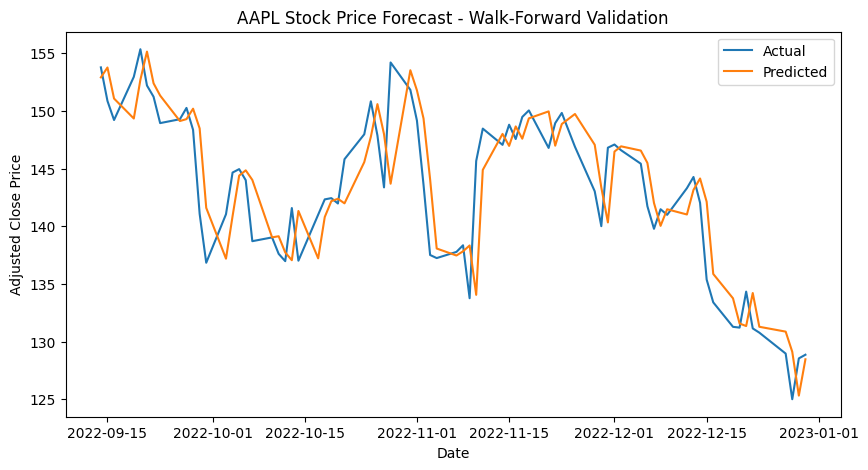

In [27]:
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Fetch data
data = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
prices = data['Adj Close']

# Define the training and test data split
n_train = int(len(prices) * 0.9)

# Walk-forward validation
history = prices[:n_train].tolist()
predictions = []
actuals = []

for t in range(n_train, len(prices)):
    model = ARIMA(history, order=(1,1,1))  # example order, adjust based on your ACF/PACF analysis
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = prices[t]
    actuals.append(obs)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

# Evaluate forecasts
rmse = np.sqrt(mean_squared_error(actuals, predictions))
print('Test RMSE: %.3f' % rmse)

# Plot forecasts against actual outcomes
plt.figure(figsize=(10, 5))
plt.plot(prices.index[n_train:], actuals, label='Actual')
plt.plot(prices.index[n_train:], predictions, label='Predicted')
plt.legend()
plt.title('AAPL Stock Price Forecast - Walk-Forward Validation')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.show()
